In [35]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

In [17]:
# Check if a GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Define data preprocessing and augmentation for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Load pre-trained EfficientNetB0 from torchvision
model = models.efficientnet_b0(pretrained=True)

c:\Users\Tuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Modify the classifier to fit the number of classes in CIFAR-10 (10 classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

In [22]:
# Move the model to the GPU (if available)
model = model.to(device)

In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [24]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = total_correct / total
    return running_loss / len(train_loader), accuracy

In [25]:
# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = total_correct / total
    return running_loss / len(test_loader), accuracy

In [28]:
# Train the model and display progress for each batch
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Set model to training mode
    model.train()
    running_loss = 0.0
    total_correct = 0
    total = 0

    # Training loop
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print statistics every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {running_loss / (batch_idx + 1):.4f}, '
                  f'Accuracy: {total_correct / total:.4f}')

    # After each epoch, evaluate on test data
    model.eval()
    test_loss = 0.0
    total_test_correct = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = total_correct / total
    test_loss = test_loss / len(test_loader)
    test_acc = total_test_correct / total_test

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/10
Batch [100/1563], Loss: 0.8206, Accuracy: 0.7675
Batch [200/1563], Loss: 0.6741, Accuracy: 0.7997
Batch [300/1563], Loss: 0.5752, Accuracy: 0.8257
Batch [400/1563], Loss: 0.5208, Accuracy: 0.8387
Batch [500/1563], Loss: 0.4793, Accuracy: 0.8506
Batch [600/1563], Loss: 0.4527, Accuracy: 0.8588
Batch [700/1563], Loss: 0.4302, Accuracy: 0.8651
Batch [800/1563], Loss: 0.4147, Accuracy: 0.8692
Batch [900/1563], Loss: 0.3984, Accuracy: 0.8739
Batch [1000/1563], Loss: 0.3859, Accuracy: 0.8775
Batch [1100/1563], Loss: 0.3743, Accuracy: 0.8808
Batch [1200/1563], Loss: 0.3642, Accuracy: 0.8838
Batch [1300/1563], Loss: 0.3541, Accuracy: 0.8869
Batch [1400/1563], Loss: 0.3450, Accuracy: 0.8895
Batch [1500/1563], Loss: 0.3362, Accuracy: 0.8922
Epoch [1/10], Train Loss: 0.3319, Train Accuracy: 0.8937, Test Loss: 0.1338, Test Accuracy: 0.9563

Epoch 2/10
Batch [100/1563], Loss: 0.1422, Accuracy: 0.9569
Batch [200/1563], Loss: 0.1467, Accuracy: 0.9545
Batch [300/1563], Loss: 0.1481, Accura

In [29]:
# Save the trained model
torch.save(model.state_dict(), "efficientnet_cifar10.pth")

In [30]:
# Testing on a few images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [32]:
# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use `next()` to get the next batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


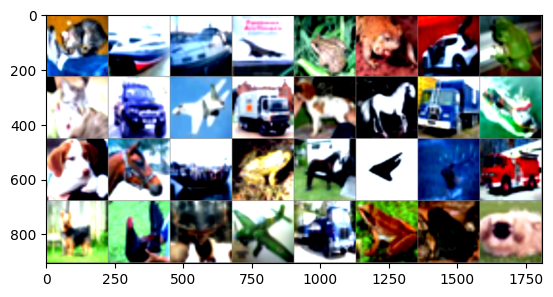

In [36]:
# Print images
imshow(torchvision.utils.make_grid(images))

In [37]:
# Move images to GPU if available
images = images.to(device)

In [38]:
# Predict
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

In [39]:
# Print predicted labels
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(4)))

Predicted:  3 8 8 0


In [40]:
# Print true labels
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))

GroundTruth:  3 8 8 0
